In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2023-01-06 18:15:06.879342: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-06 18:15:20.043958: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-01-06 18:15:20.086578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-06 18:15:20.086614: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-06 18:15:20.088798: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-01-06 18:15:20.090974: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# One dimensional functions

> Here, I try to model $y=f(x)$ with a neural net by using both $y$ and $y''=f''(x)$.

In [2]:
def Gaussian(x, loc=0.0, scale=1.0):
    return np.exp(-(x-loc)**2/(2*scale**2))

def Gaussian_df_dx(x, loc=0.0, scale=1.0):
    return (-(x-loc)/(scale**2))*Gaussian(x, loc, scale)

def Gaussian_d2f_dx2(x, loc=0.0, scale=1.0):
    return ((-1.0/scale**2)*Gaussian(x, loc, scale)
            -((x-loc)/(scale**2))*Gaussian_df_dx(x, loc, scale ))

data_1d_x = np.linspace(-4, 4, 512)[:,np.newaxis].astype(np.float32)
data_1d_y_gaussian = Gaussian(data_1d_x, 1.0)
data_1d_df_dx_gaussian = Gaussian_df_dx(data_1d_x, 1.0)
data_1d_d2f_dx2_gaussian = Gaussian_d2f_dx2(data_1d_x, 1.0)


ds_gaussian = TINN_Dataset(tf.float32, 
                           np.concatenate([data_1d_x, data_1d_y_gaussian], axis=1),
                           np.concatenate([data_1d_x, data_1d_df_dx_gaussian], axis=1))

In [3]:
@tf.function
def derivatives(pinn, x):
    y = pinn.net(x)
    p1, p2 = pinn.gradients(x, y)
    return y, p1, p2

In [4]:
class NN2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        biases = []
        for i in range(0, self.num_layers - 2):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)           
            
        W = self.xavier_init(size=[self.layers[i+1], self.layers[i + 2]])
        b = tf.Variable(tf.zeros([1, self.layers[i + 2]], dtype=self.dtype), dtype=self.dtype)        
        weights.append(W)
        biases.append(b)
            
        self.Ws = weights
        self.bs = biases


    @tf.function
    def net(self, inputs):
            
        def act(x):
            
            return x*x/(1.0 + tf.math.exp(-x))
            
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0        
        for W, b in zip(self.Ws[:-1], self.bs[:-1]):
            linear_outputs = tf.add(tf.matmul(H, W), b)            
            H = act(linear_outputs)            
        W = self.Ws[-1]
        b = self.bs[-1]
        linear_outputs = tf.add(tf.matmul(H, W), b)
        return linear_outputs

In [5]:
def RMSE(pred, actual):
    return np.sqrt(np.mean((pred-actual)**2))

# 1D

In [6]:
layers = [1, 10, 1]
pinn = NN2(layers, 
             lb= np.min(data_1d_x),
             ub= np.max(data_1d_x),
             dtype=tf.float32)

2023-01-06 13:32:19.530985: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


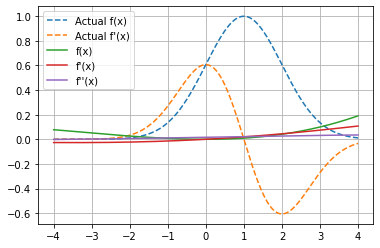

In [7]:
y, y_der_1, y_der_2 = derivatives(pinn, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian,'--', label="Actual f(x)")
plt.plot(data_1d_x, data_1d_df_dx_gaussian,'--', label="Actual f'(x)")

plt.plot(data_1d_x, y.numpy(), label="f(x)")
plt.plot(data_1d_x, y_der_1[0].numpy(), label="f'(x)")
plt.plot(data_1d_x, y_der_2[0].numpy(), label="f''(x)")
plt.legend()
plt.grid()
plt.show()

In [11]:
loss = Observation_Loss(layers, residual_ret_names=("f(x)",), print_precision = ".10f")
#loss2 = Derivatives_single_Loss(pinn.dtype, print_precision = ".10f")
model = tu.TINN(pinn, [loss], L2(),
                optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results = model.train(100000+1, 256, ds_gaussian, print_interval=5000,stop_threshold=1e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0


2023-01-05 22:17:12.050662: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


total loss: 0.4242395982, total regularised loss: 0.4242396057
Observation_Loss -> 
(1)  f(x): 0.2121197991 
Time taken: 1.07s

Start of epoch 5000
total loss: 0.0439665103, total regularised loss: 0.0439665094
Observation_Loss -> 
(1)  f(x): 0.0219832552 
Time taken: 44.63s

Start of epoch 10000
total loss: 0.0378081449, total regularised loss: 0.0378081463
Observation_Loss -> 
(1)  f(x): 0.0189040725 
Time taken: 44.86s

Start of epoch 15000
total loss: 0.0286760749, total regularised loss: 0.0286760740
Observation_Loss -> 
(1)  f(x): 0.0143380375 
Time taken: 44.82s

Start of epoch 20000
total loss: 0.0121674063, total regularised loss: 0.0121674063
Observation_Loss -> 
(1)  f(x): 0.0060837031 
Time taken: 44.68s

Start of epoch 25000
total loss: 0.0017158255, total regularised loss: 0.0017158255
Observation_Loss -> 
(1)  f(x): 0.0008579128 
Time taken: 45.62s

Start of epoch 30000
total loss: 0.0013036389, total regularised loss: 0.0013036389
Observation_Loss -> 
(1)  f(x): 0.00065

In [13]:
results1_2 = model.train(100000+1, 256, ds_gaussian, print_interval=5000,stop_threshold=1e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.0001154656, total regularised loss: 0.0001154656
Observation_Loss -> 
(1)  f(x): 0.0000577328 
Time taken: 0.14s

Start of epoch 5000
total loss: 0.0001053992, total regularised loss: 0.0001053992
Observation_Loss -> 
(1)  f(x): 0.0000526996 
Time taken: 45.84s

Start of epoch 10000
total loss: 0.0000953132, total regularised loss: 0.0000953132
Observation_Loss -> 
(1)  f(x): 0.0000476566 
Time taken: 44.64s

Start of epoch 15000
total loss: 0.0000853182, total regularised loss: 0.0000853182
Observation_Loss -> 
(1)  f(x): 0.0000426591 
Time taken: 45.54s

Start of epoch 20000
total loss: 0.0000753444, total regularised loss: 0.0000753444
Observation_Loss -> 
(1)  f(x): 0.0000376722 
Time taken: 46.05s

Start of epoch 25000
total loss: 0.0000658189, total regularised loss: 0.0000658190
Observation_Loss -> 
(1)  f(x): 0.0000329095 
Time taken: 47.20s

Start of epoch 30000
total loss: 0.0000576537, total regularised loss: 0.0000576537
Observation_Loss -> 


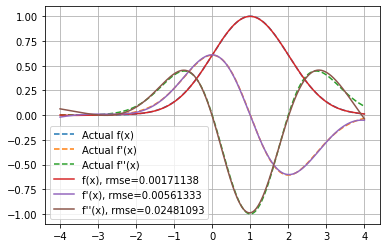

In [29]:
y, y_der_1, y_der_2 = derivatives(pinn, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian,'--', label="Actual f(x)")
plt.plot(data_1d_x, data_1d_df_dx_gaussian,'--', label="Actual f'(x)")
plt.plot(data_1d_x, data_1d_d2f_dx2_gaussian,'--', label="Actual f''(x)")


plt.plot(data_1d_x, y.numpy(), label=f"f(x), rmse={RMSE(data_1d_y_gaussian, y.numpy()):.8f}")
plt.plot(data_1d_x, y_der_1[0].numpy(),
         label=f"f'(x), rmse={RMSE(data_1d_df_dx_gaussian, y_der_1[0].numpy()):.8f}")

plt.plot(data_1d_x, y_der_2[0].numpy(), 
         label=f"f''(x), rmse={RMSE(data_1d_d2f_dx2_gaussian, y_der_2[0].numpy()):.8f}")
plt.legend()
plt.grid()
plt.show()

# Adding the derivative loss

In [6]:
class Derivatives_single_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 1,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=1,
            residual_ret_names=("df/dx",),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        df_dx = tf.gradients(outputs, inputs)[0]           
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        print(df_dx.shape)
        print(df_dx_obs.shape)

        return (df_dx - df_dx_obs,)

class Derivatives_double_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 1,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("df/dx", "d2f/dx2"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        df_dx = tf.gradients(outputs, inputs)[0]
        d2f_dx2 = tf.gradients(df_dx, inputs)[0]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        d2f_dx2_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        
        print(df_dx.shape)
        print(d2f_dx2.shape)
        print(df_dx_obs.shape)
        print(d2f_dx2_obs.shape)

        return (df_dx - df_dx_obs, d2f_dx2-d2f_dx2_obs)


In [9]:
layers2 = [1, 10, 1]
pinn2 = NN2(layers2, 
             lb= np.min(data_1d_x),
             ub= np.max(data_1d_x),
             dtype=tf.float32)

In [18]:
loss = Observation_Loss(layers2, residual_ret_names=("f(x)",), print_precision = ".10f")
loss2 = Derivatives_single_Loss(pinn2.dtype, print_precision = ".10f")
model2 = tu.TINN(pinn2, [loss, loss2], L2(),
                optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results = model2.train(100000+1, 256, ds_gaussian, print_interval=5000,stop_threshold=1e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.6654357873, total regularised loss: 0.6654357910
Observation_Loss -> 
(1)  f(x): 0.2170001771 
Derivatives_Loss -> 
(2)  df/dx: 0.1157177165 
Time taken: 1.91s

Start of epoch 5000
total loss: 0.2622548845, total regularised loss: 0.2622548938
Observation_Loss -> 
(1)  f(x): 0.0477750255 
Derivatives_Loss -> 
(2)  df/dx: 0.0833524168 
Time taken: 86.04s

Start of epoch 10000
total loss: 0.1995471790, total regularised loss: 0.1995471716
Observation_Loss -> 
(1)  f(x): 0.0255067702 
Derivatives_Loss -> 
(2)  df/dx: 0.0742668193 
Time taken: 88.17s

Start of epoch 15000
total loss: 0.1873210063, total regularised loss: 0.1873210073
Observation_Loss -> 
(1)  f(x): 0.0232451144 
Derivatives_Loss -> 
(2)  df/dx: 0.0704153888 
Time taken: 86.17s

Start of epoch 20000
total loss: 0.1556874113, total regularised loss: 0.1556874067
Observation_Loss -> 
(1)  f(x): 0.0191560374 
Derivatives_Loss -> 
(2)  df/dx: 0.0586876683 
Time taken: 87.01s

Start of epoch 25000

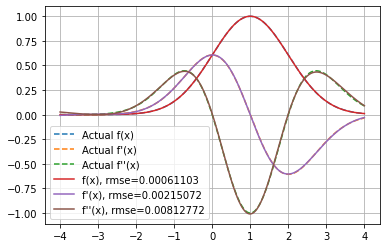

In [27]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian,'--', label="Actual f(x)")
plt.plot(data_1d_x, data_1d_df_dx_gaussian,'--', label="Actual f'(x)")
plt.plot(data_1d_x, data_1d_d2f_dx2_gaussian,'--', label="Actual f''(x)")


plt.plot(data_1d_x, y.numpy(), label=f"f(x), rmse={RMSE(data_1d_y_gaussian, y.numpy()):.8f}")
plt.plot(data_1d_x, y_der_1[0].numpy(),
         label=f"f'(x), rmse={RMSE(data_1d_df_dx_gaussian, y_der_1[0].numpy()):.8f}")

plt.plot(data_1d_x, y_der_2[0].numpy(), 
         label=f"f''(x), rmse={RMSE(data_1d_d2f_dx2_gaussian, y_der_2[0].numpy()):.8f}")
plt.legend()
plt.grid()
plt.show()

# Adding the second derivative loss

In [10]:
ds_gaussian2 = TINN_Dataset(tf.float32, 
                           np.concatenate([data_1d_x, data_1d_y_gaussian], axis=1),
                           np.concatenate([data_1d_x, data_1d_df_dx_gaussian, data_1d_d2f_dx2_gaussian], axis=1))

In [11]:
layers3 = [1, 10, 1]
pinn3 = NN2(layers3, 
             lb= np.min(data_1d_x),
             ub= np.max(data_1d_x),
             dtype=tf.float32)

In [12]:
loss = Observation_Loss(layers3, residual_ret_names=("f(x)",), print_precision = ".10f")
loss2 = Derivatives_double_Loss(pinn3.dtype, print_precision = ".10f")
model3 = tu.TINN(pinn3, [loss, loss2], L2(),
                optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results = model3.train(100000+1, 256, ds_gaussian2, print_interval=5000,stop_threshold=1e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
(256, 1)
(256, 1)
(256, 1)
(256, 1)


2023-01-06 13:33:31.434357: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


total loss: 0.9971687645, total regularised loss: 0.9971688390
Observation_Loss -> 
(1)  f(x): 0.2169933245 
Derivatives_Loss -> 
(2)  df/dx: 0.1158378348 (3)  d2f/dx2: 0.1657532211 
Time taken: 5.37s

Start of epoch 5000
total loss: 0.5781576410, total regularised loss: 0.5781576633
Observation_Loss -> 
(1)  f(x): 0.0421272069 
Derivatives_Loss -> 
(2)  df/dx: 0.0778819025 (3)  d2f/dx2: 0.1690697111 
Time taken: 104.22s

Start of epoch 10000
total loss: 0.5503426492, total regularised loss: 0.5503426790
Observation_Loss -> 
(1)  f(x): 0.0303633884 
Derivatives_Loss -> 
(2)  df/dx: 0.0715544317 (3)  d2f/dx2: 0.1732535064 
Time taken: 101.97s

Start of epoch 15000
total loss: 0.5321471877, total regularised loss: 0.5321471691
Observation_Loss -> 
(1)  f(x): 0.0278894473 
Derivatives_Loss -> 
(2)  df/dx: 0.0686431099 (3)  d2f/dx2: 0.1695410274 
Time taken: 118.65s

Start of epoch 20000
total loss: 0.4745481508, total regularised loss: 0.4745481610
Observation_Loss -> 
(1)  f(x): 0.022818

In [14]:
results3_2 = model3.train(100000+1, 256, ds_gaussian2, print_interval=5000,stop_threshold=1e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.0004586950, total regularised loss: 0.0004586950
Observation_Loss -> 
(1)  f(x): 0.0000010878 
Derivatives_Loss -> 
(2)  df/dx: 0.0000132380 (3)  d2f/dx2: 0.0002150217 
Time taken: 0.07s

Start of epoch 5000
total loss: 0.0004521118, total regularised loss: 0.0004521117
Observation_Loss -> 
(1)  f(x): 0.0000010682 
Derivatives_Loss -> 
(2)  df/dx: 0.0000129962 (3)  d2f/dx2: 0.0002119915 
Time taken: 100.87s

Start of epoch 10000
total loss: 0.0004456911, total regularised loss: 0.0004456911
Observation_Loss -> 
(1)  f(x): 0.0000010468 
Derivatives_Loss -> 
(2)  df/dx: 0.0000127808 (3)  d2f/dx2: 0.0002090180 
Time taken: 100.36s

Start of epoch 15000
total loss: 0.0004393712, total regularised loss: 0.0004393712
Observation_Loss -> 
(1)  f(x): 0.0000010289 
Derivatives_Loss -> 
(2)  df/dx: 0.0000125705 (3)  d2f/dx2: 0.0002060863 
Time taken: 101.31s

Start of epoch 20000
total loss: 0.0004342180, total regularised loss: 0.0004342181
Observation_Loss -> 
(

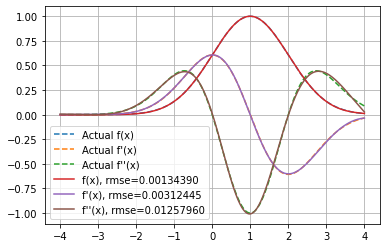

In [15]:
y, y_der_1, y_der_2 = derivatives(pinn3, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian,'--', label="Actual f(x)")
plt.plot(data_1d_x, data_1d_df_dx_gaussian,'--', label="Actual f'(x)")
plt.plot(data_1d_x, data_1d_d2f_dx2_gaussian,'--', label="Actual f''(x)")


plt.plot(data_1d_x, y.numpy(), label=f"f(x), rmse={RMSE(data_1d_y_gaussian, y.numpy()):.8f}")
plt.plot(data_1d_x, y_der_1[0].numpy(),
         label=f"f'(x), rmse={RMSE(data_1d_df_dx_gaussian, y_der_1[0].numpy()):.8f}")

plt.plot(data_1d_x, y_der_2[0].numpy(), 
         label=f"f''(x), rmse={RMSE(data_1d_d2f_dx2_gaussian, y_der_2[0].numpy()):.8f}")
plt.legend()
plt.grid()
plt.show()

# Two-dimensional Model

In [7]:
class Derivatives_2d_single_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("df/dx", "df/dy"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]        
        df_dx = r[:,0:1]
        df_dy = r[:,1:2]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        df_dy_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        print(df_dx.shape)
        print(df_dy.shape)
        print(df_dx_obs.shape)
        print(df_dy_obs.shape)
        return (df_dx - df_dx_obs, df_dy - df_dy_obs)

class Derivatives_2d_double_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=4,
            residual_ret_names=("df/dx", "df/dy", "d2f/dx2", "d2f/dy2"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]
        df_dx = r[:,0:1]
        df_dy = r[:,1:2]
        r2 = tf.gradients(r, inputs)[0]
        d2f_dx2 = r2[:,0:1]
        d2f_dy2 = r2[:,1:2]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        df_dy_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        d2f_dx2_obs = x[:, self.input_dim+2 : self.input_dim + 3]
        d2f_dy2_obs = x[:, self.input_dim+3 : self.input_dim + 4]
        
        print(df_dx.shape)
        print(df_dy.shape)
        print(d2f_dx2.shape)
        print(d2f_dy2.shape)
        print(df_dx_obs.shape)
        print(df_dy_obs.shape)
        print(d2f_dx2_obs.shape)
        print(d2f_dy2_obs.shape)

        return (df_dx - df_dx_obs,
                df_dy - df_dy_obs,
                d2f_dx2-d2f_dx2_obs,
                d2f_dy2-d2f_dy2_obs)


In [8]:
def Gaussian_2d(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return np.exp(-(x-locx)**2/(2*scalex**2)-(y-locy)**2/(2*scaley**2))

def Gaussian_2d_df_dx(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(x-locx)/(scalex**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_df_dy(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(y-locy)/(scaley**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_d2f_dx2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scalex**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley)
            -((x-locx)/(scalex**2))*Gaussian_2d_df_dx(x, y, locx, locy, scalex, scaley))

def Gaussian_2d_d2f_dy2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scaley**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley) 
            -((y-locy)/(scaley**2))*Gaussian_2d_df_dy(x, y, locx, locy, scalex, scaley))


data_2d_x = np.linspace(0, 2, 128)[:,np.newaxis].astype(np.float32)
data_2d_y = np.linspace(-2, 2, 128)[:,np.newaxis].astype(np.float32)
X,Y = np.meshgrid(data_2d_x, data_2d_y,indexing='ij')
data_2d_z_gaussian = Gaussian_2d(X, Y, 1.0, 0.5, .2, .7)
data_input = np.concatenate([X.flatten()[:,np.newaxis],
                             Y.flatten()[:,np.newaxis]], 
                              axis=1)

data_2d_df_dx = Gaussian_2d_df_dx(X, Y, 1.0, 0.5, .2, .7)
data_2d_df_dy = Gaussian_2d_df_dy(X, Y, 1.0, 0.5, .2, .7)

data_2d_d2f_dx2 = Gaussian_2d_d2f_dx2(X, Y, 1.0, 0.5, .2, .7)
data_2d_d2f_dy2 = Gaussian_2d_d2f_dy2(X, Y, 1.0, 0.5, .2, .7)

ds_gaussian_2d = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_df_dx.flatten()[:,np.newaxis],
                                              data_2d_df_dy.flatten()[:,np.newaxis]], axis=1)
                              )

ds_gaussian_2d_all_ders = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_df_dx.flatten()[:,np.newaxis],
                                              data_2d_df_dy.flatten()[:,np.newaxis],
                                              data_2d_d2f_dx2.flatten()[:,np.newaxis],
                                              data_2d_d2f_dy2.flatten()[:,np.newaxis]], axis=1)
                              )


def plot(X, Y, Z, title=""):
    plt.title(title)    
    plt.contourf(X, Y, Z)    
    plt.colorbar()


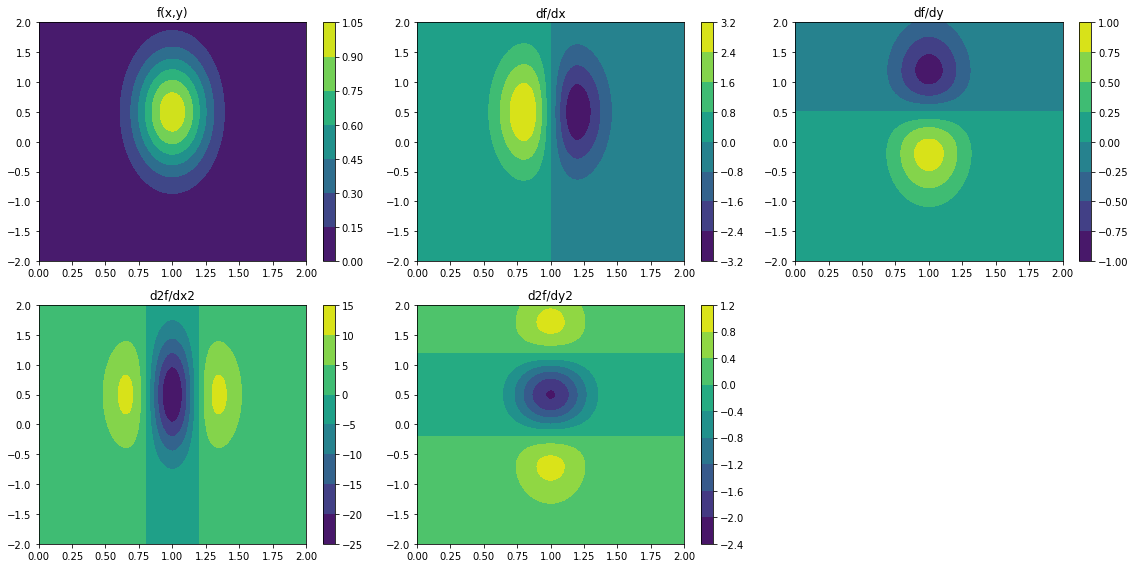

In [9]:
_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, data_2d_z_gaussian, "f(x,y)")
plt.subplot(232)
plot(X, Y, Gaussian_2d_df_dx(X, Y, 1.0, 0.5, .2, .7), "df/dx")
plt.subplot(233)
plot(X, Y, Gaussian_2d_df_dy(X, Y, 1.0, 0.5, .2, .7), "df/dy")
plt.subplot(234)
plot(X, Y, Gaussian_2d_d2f_dx2(X, Y, 1.0, 0.5, .2, .7), "d2f/dx2")
plt.subplot(235)
plot(X, Y, Gaussian_2d_d2f_dy2(X, Y, 1.0, 0.5, .2, .7), "d2f/dy2")
plt.tight_layout()
plt.show()

In [10]:
def to_2d(x):
    return x.reshape((data_2d_x.shape[0], data_2d_x.shape[0]))

In [23]:
layers2 = [2, 128, 128, 1]
pinn2 = NN2(layers2, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

# Initial output of an untrained network

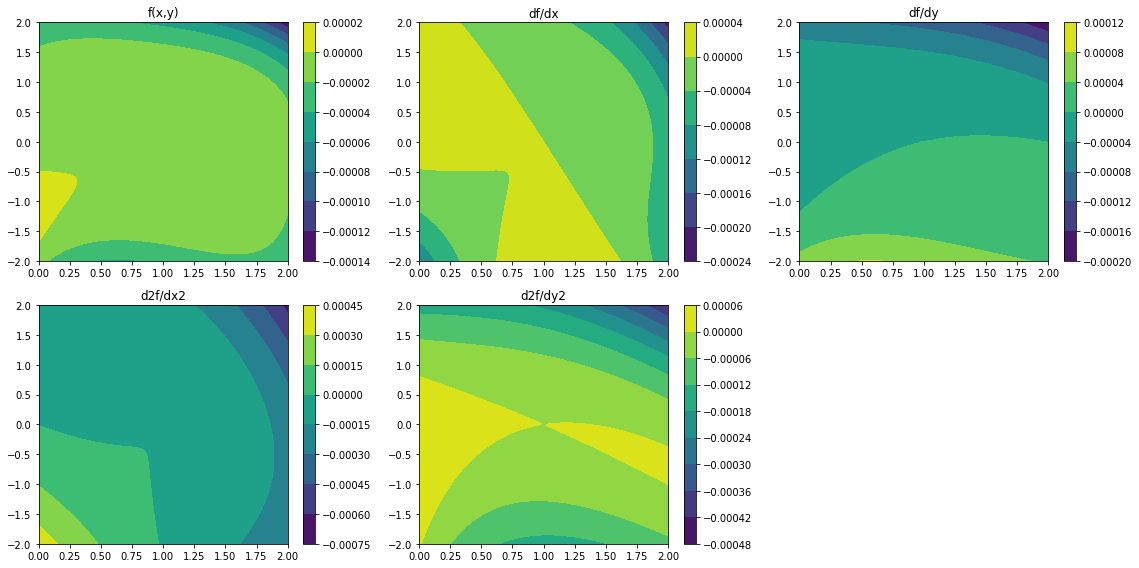

In [24]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), "f(x,y)")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), "df/dx")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), "df/dy")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), "d2f/dx2")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), "d2f/dy2")
plt.tight_layout()
plt.show()

# Train the model

In [25]:
loss2_1 = Observation_Loss(layers2, residual_ret_names=("f(x,y)",), print_precision = ".10f")
loss2_2 = Derivatives_2d_single_Loss(pinn2.dtype, print_precision = ".10f")
model2 = tu.TINN(pinn2, [loss2_1, loss2_2], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results2 = model2.train(100000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=1e-6,
                        regularise=False, sample_regularisations=False)


Start of epoch 0
(4096, 1)
(4096, 1)
(4096, 1)
(4096, 1)
total loss: 3.1374228710, total regularised loss: 3.1374228001
Observation_Loss -> 
(1)  f(x,y): 0.0540344469 
Derivatives_Loss -> 
(2)  df/dx: 0.6757794895 (3)  df/dy: 0.0545417944 
Time taken: 4.15s

Start of epoch 5000
total loss: 0.0081397286, total regularised loss: 0.0081397286
Observation_Loss -> 
(1)  f(x,y): 0.0000099881 
Derivatives_Loss -> 
(2)  df/dx: 0.0019340711 (3)  df/dy: 0.0000908730 
Time taken: 262.72s

Start of epoch 10000
total loss: 0.0004556261, total regularised loss: 0.0004556261
Observation_Loss -> 
(1)  f(x,y): 0.0000005552 
Derivatives_Loss -> 
(2)  df/dx: 0.0001048280 (3)  df/dy: 0.0000085233 
Time taken: 264.34s

Start of epoch 15000
total loss: 0.0003228732, total regularised loss: 0.0003228732
Observation_Loss -> 
(1)  f(x,y): 0.0000002932 
Derivatives_Loss -> 
(2)  df/dx: 0.0000754587 (3)  df/dy: 0.0000049664 
Time taken: 261.28s

Start of epoch 20000
total loss: 0.0002533735, total regularised l

In [26]:
model2.save(".", "model2d_x_2_sigmoid_first_ders")

In [17]:
model2 = tu.TINN.restore(".", "model2", ds_gaussian_2d2)
pinn2 = model2.pinn

2023-01-06 13:30:00.791558: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-01-06 13:30:01.023528: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [29]:
y_test, y_der_1_test, y_der_2_test = derivatives(pinn2, data_input)

def RMSE(pred, actual):
    return np.sqrt(np.mean((pred-actual)**2))
    #return np.mean((pred-actual)**2)

print(f"f(x)    RMSE: {RMSE(to_2d(y_test.numpy()), data_2d_z_gaussian) :.8f}")
print(f"df/dx   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,0]), data_2d_df_dx) :.8f}")
print(f"df/dy   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,1]), data_2d_df_dy) :.8f}")
print(f"d2f/dx2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,0]), data_2d_d2f_dx2) :.8f}")
print(f"d2f/dy2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,1]), data_2d_d2f_dy2) :.8f}")

f(x)    RMSE: 0.00019831
df/dx   RMSE: 0.00339868
df/dy   RMSE: 0.00091782
d2f/dx2 RMSE: 0.82949084
d2f/dy2 RMSE: 0.82565850


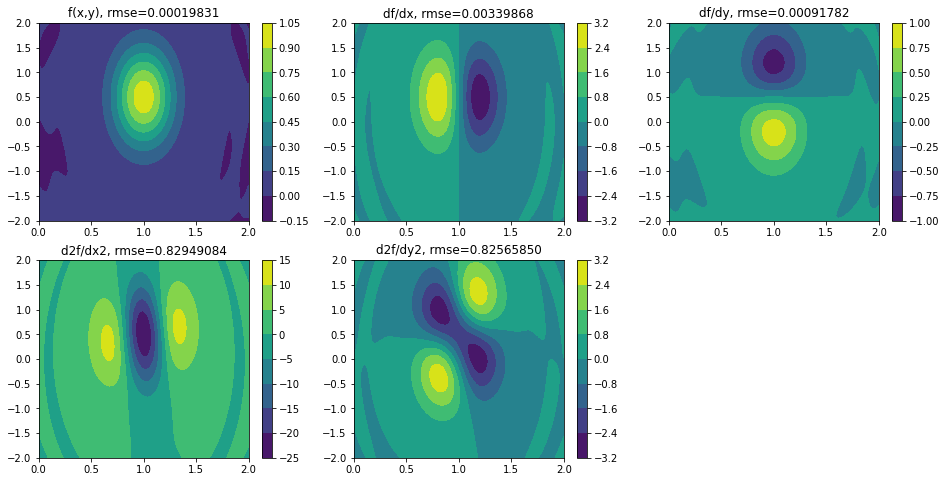

In [30]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.8f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.8f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.8f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.8f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.8f}")
plt.show()

In [11]:
def RMSE(pred, actual, sqrt=True):
    if sqrt:
        return np.sqrt(np.mean((pred-actual)**2))
    else:
        return np.mean((pred-actual)**2)

# After training

In [36]:
y_test, y_der_1_test, y_der_2_test = derivatives(pinn2, data_input)



print(f"f(x)    RMSE: {RMSE(to_2d(y_test.numpy()), data_2d_z_gaussian) :.8f}")
print(f"df/dx   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,0]), data_2d_df_dx) :.8f}")
print(f"df/dy   RMSE: {RMSE(to_2d(y_der_1_test[0].numpy()[:,1]), data_2d_df_dy) :.8f}")
print(f"d2f/dx2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,0]), data_2d_d2f_dx2) :.8f}")
print(f"d2f/dy2 RMSE: {RMSE(to_2d(y_der_2_test[0].numpy()[:,1]), data_2d_d2f_dy2) :.8f}")

f(x)    RMSE: 0.00019831
df/dx   RMSE: 0.00339868
df/dy   RMSE: 0.00091782
d2f/dx2 RMSE: 0.82949084
d2f/dy2 RMSE: 0.82565850


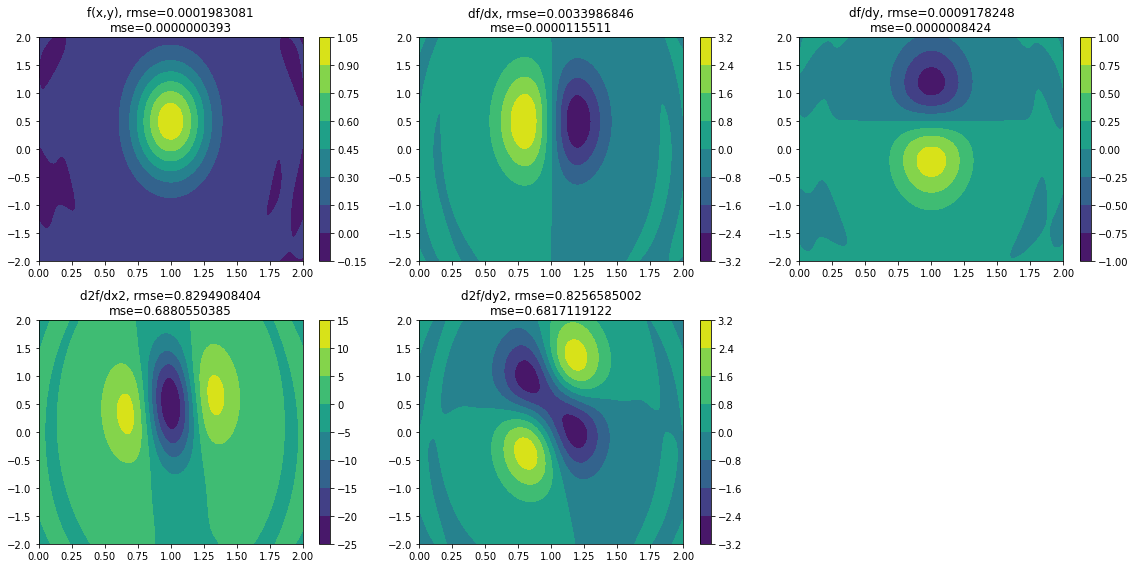

In [41]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

# Including second derivatives

In [12]:
layers3 = [2, 128, 128, 1]
pinn3 = NN2(layers3, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

2023-01-06 18:16:35.076667: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


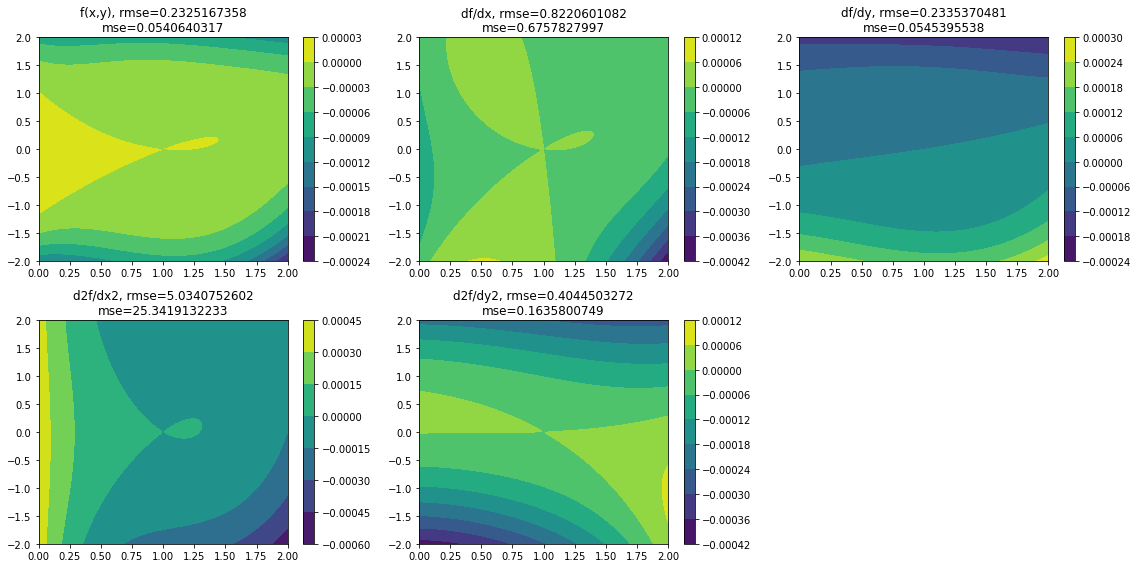

In [13]:
y, y_der_1, y_der_2 = derivatives(pinn3, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [ ]:
loss2_1 = Observation_Loss(layers3, residual_ret_names=("f(x,y)",), print_precision = ".10f")
loss2_2 = Derivatives_2d_double_Loss(pinn3.dtype, print_precision = ".10f")
model3 = tu.TINN(pinn3, [loss2_1, loss2_2], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results3 = model3.train(50000+1, 4096, ds_gaussian_2d_all_ders, print_interval=1000,stop_threshold=1e-6,
                        regularise=True, sample_regularisations=True)


Start of epoch 0
(4096, 1)
(4096, 1)
(4096, 1)
(4096, 1)
(4096, 1)
(4096, 1)
(4096, 1)
(4096, 1)


2023-01-06 18:16:49.961254: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


total loss: 105.1593101394, total regularised loss: 105.1593017578
Observation_Loss -> 
(1)  f(x,y): 0.0540345702 
Derivatives_Loss -> 
(2)  df/dx: 0.6757865958 (3)  df/dy: 0.0545399586 (4)  d2f/dx2: 25.3418866247 
(5)  d2f/dy2: 0.1635794528 
(1) lambdas : 1.0000000000 (2) lambdas : 1.0000000000 (3) lambdas : 1.0000000000 
(4) lambdas : 1.0000000000 (5) lambdas : 1.0000000000 
Time taken: 25.96s

Start of epoch 1000
total loss: 86.0739971101, total regularised loss: 406.2177124023
Observation_Loss -> 
(1)  f(x,y): 0.1850216612 
Derivatives_Loss -> 
(2)  df/dx: 0.4048972614 (3)  df/dy: 0.0559183782 (4)  d2f/dx2: 20.6513530612 
(5)  d2f/dy2: 0.2213073848 
(1) lambdas : 0.0086616632 (2) lambdas : 0.0369640626 (3) lambdas : 0.0047001760 
(4) lambdas : 4.9163923264 (5) lambdas : 0.0332819186 
Time taken: 174.80s

Start of epoch 2000
total loss: 13.5778467655, total regularised loss: 26.5726509094
Observation_Loss -> 
(1)  f(x,y): 0.2651006430 
Derivatives_Loss -> 
(2)  df/dx: 0.4311358780 (